## Import dependencies

In [1]:
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql import *
import pixiedust
from pyspark.sql.types import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import csv

Pixiedust database opened successfully


### Read in data, create schema for dataframe

In [2]:
sc = spark.sparkContext # this is the Driver Program

input_file_template="hdfs://saltdean/data/reviews/Reviews.csv"
df = sqlContext.read. \
  format("com.databricks.spark.csv"). \
  option("header","true"). \
  load(input_file_template)

In [3]:
df.dtypes

[('Id', 'string'),
 ('ProductId', 'string'),
 ('UserId', 'string'),
 ('ProfileName', 'string'),
 ('HelpfulnessNumerator', 'string'),
 ('HelpfulnessDenominator', 'string'),
 ('Score', 'string'),
 ('Time', 'string'),
 ('Summary', 'string'),
 ('Text', 'string')]

### Drop irrelevant columns

In [4]:
# drop all but the most important (consider adding back later)
df = df.drop(df.Id).drop(df.ProductId).drop(df.ProfileName).drop(df.Summary)

In [5]:
#df = df.sample(False, 0.25)

## Inspect the data

#### Show Helpfulness measure: numerator and denominator

In [6]:
from pyspark.sql import functions as F
df.select("HelpfulnessNumerator", "HelpfulnessDenominator").show(10)

+--------------------+----------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|
+--------------------+----------------------+
|                   1|                     1|
|                   0|                     0|
|                   1|                     1|
|                   3|                     3|
|                   0|                     0|
|                   0|                     0|
|                   0|                     0|
|                   0|                     0|
|                   1|                     1|
|                   0|                     0|
+--------------------+----------------------+
only showing top 10 rows



#### Inspect rows that have no ratings

In [7]:
# look at rows that have a numerator and denominator of zero
df.filter((df['HelpfulnessNumerator'] == 0) & (df['HelpfulnessDenominator'] == 0)).show(10)


+--------------+--------------------+----------------------+-----+----------+--------------------+
|        UserId|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                Text|
+--------------+--------------------+----------------------+-----+----------+--------------------+
|A1D87F6ZCVE5NK|                   0|                     0|    1|1346976000|"Product arrived ...|
|A1UQRSCLF8GW1T|                   0|                     0|    5|1350777600|Great taffy at a ...|
| ADT0SRK1MGOEU|                   0|                     0|    4|1342051200|I got a wild hair...|
|A1SP2KVKFXXRU1|                   0|                     0|    5|1340150400|This saltwater ta...|
|A3JRGQVEQN31IQ|                   0|                     0|    5|1336003200|This taffy is so ...|
|A21BT40VZCCYT4|                   0|                     0|    5|1351209600|This is a very he...|
|A3KLWF6WQ5BNYO|                   0|                     0|    2|1348099200|I love eating the...|
| AFKW14U9

## Feature generation, data wrangling

#### Remove rows with no reviews and show result

In [8]:
# remove rows which have no reviews
df = df.filter((df['HelpfulnessNumerator'] != 0) & (df['HelpfulnessDenominator'] != 0))

#### Remove reviews with less than 4 helpfulness votes

In [9]:
df = df.filter(df['HelpfulnessDenominator'] >= 4)

#### Create new ratio variable: Helpfullness numerator / helpfulness denominator...

In [10]:
df_new = df.withColumn('target', df.HelpfulnessNumerator / df.HelpfulnessDenominator)

In [11]:
df_new.show(5)

+--------------+--------------------+----------------------+-----+----------+--------------------+------+
|        UserId|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                Text|target|
+--------------+--------------------+----------------------+-----+----------+--------------------+------+
|A2725IB4YY9JEB|                   4|                     4|    5|1282867200|One of my boys ne...|   1.0|
|A2MUGFV2TDQ47K|                   4|                     5|    5|1268352000|The Strawberry Tw...|   0.8|
|A1CZX3CP8IKQIJ|                   4|                     5|    5|1262044800|My daughter loves...|   0.8|
| AOVROBZ8BNTP7|                  19|                    19|    4|1163376000|McCann's Instant ...|   1.0|
|A3PMM0NFVEJGK9|                  13|                    13|    4|1166313600|This is a good in...|   1.0|
+--------------+--------------------+----------------------+-----+----------+--------------------+------+
only showing top 5 rows



In [12]:
df_ones = df_new.filter(df_new['target'] >= '0.75')
print('Proportion of examples with a helpfulness ratio >= 0.75:', df_ones.count()/df_new.count())


Proportion of examples with a helpfulness ratio >= 0.75: 0.7087576374745418


#### ... from that create a binary target variable: '1' if ratio is above 0.75

In [13]:
# create a new column 'veryHelpful' that will serve as the target variable 
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
veryHelpful_udf = udf(lambda target: '1' if target >= 0.75 else '0', StringType()) # EXPLAIN WHAT UDF DOES

df = df_new.withColumn("veryHelpful", veryHelpful_udf(df_new.target))
df.show(10)

+--------------+--------------------+----------------------+-----+----------+--------------------+------+-----------+
|        UserId|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                Text|target|veryHelpful|
+--------------+--------------------+----------------------+-----+----------+--------------------+------+-----------+
|A2725IB4YY9JEB|                   4|                     4|    5|1282867200|One of my boys ne...|   1.0|          1|
|A2MUGFV2TDQ47K|                   4|                     5|    5|1268352000|The Strawberry Tw...|   0.8|          1|
|A1CZX3CP8IKQIJ|                   4|                     5|    5|1262044800|My daughter loves...|   0.8|          1|
| AOVROBZ8BNTP7|                  19|                    19|    4|1163376000|McCann's Instant ...|   1.0|          1|
|A3PMM0NFVEJGK9|                  13|                    13|    4|1166313600|This is a good in...|   1.0|          1|
|A2EB6OGOWCRU5H|                   9|                   

#### Bring relevant columns forward and change label to double (for compatibility with ML pipeline)

In [14]:
df = df.drop("HelpfulnessNumerator").drop("HelpfulnessDenominator").drop("target").drop("Time") # drop columns no longer needed
df = df.select("veryHelpful", "Text", "Score", "UserId")# change order of columns
df = df.withColumnRenamed("veryHelpful", "label") # rename binary target column to "label", in-keeping with pipeline terminology
df = df.select(df.label.cast("double"), df.Text, df.Score, df.UserId) # convert labels from strings to double (some ML algorithms dislike floats)
df.show(10)

+-----+--------------------+-----+--------------+
|label|                Text|Score|        UserId|
+-----+--------------------+-----+--------------+
|  1.0|One of my boys ne...|    5|A2725IB4YY9JEB|
|  1.0|The Strawberry Tw...|    5|A2MUGFV2TDQ47K|
|  1.0|My daughter loves...|    5|A1CZX3CP8IKQIJ|
|  1.0|McCann's Instant ...|    4| AOVROBZ8BNTP7|
|  1.0|This is a good in...|    4|A3PMM0NFVEJGK9|
|  1.0|Instant oatmeal c...|    5|A2EB6OGOWCRU5H|
|  1.0|"Got a free packa...|    5|A3S5KJDA6ED2PS|
|  0.0|Watch your prices...|    3|A1ZR8O62VSU4OK|
|  1.0|"I know the produ...|    5|A2VOZX7YBT0D6D|
|  1.0|While my dogs lik...|    3|A1FD9E5C06UB6B|
+-----+--------------------+-----+--------------+
only showing top 10 rows



### Create a feature that shows how many times a user has posted

#### First, remove duplicate reviews that will skew the 'count' variable:

When a product has slight variations (e.g. different colour options), a user review is applied to all numerous product IDs.

The duplicate examples are identical in every way except product ID. I.e. the text is exactly the same.

In [15]:
df = df.dropDuplicates()

#### Now create the count column that will identify which users have genuinely posted more than once.

In [16]:
from pyspark.sql import functions as F

# aggregate the data
df_count = df.groupby('UserId').agg(F.count("Score").alias("reviewCount"))

# append back to df
df = df.join(df_count, 'UserId')
df.show(10)
df.count()

+------------------+-----+--------------------+-----+-----------+
|            UserId|label|                Text|Score|reviewCount|
+------------------+-----+--------------------+-----+-----------+
|#oc-R35YUP5T21KW2U|  0.0|Extremely disappo...|    1|          1|
|    A10AZVYK32ZJSE|  1.0|Got this item bec...|    4|          1|
|    A10Q1QIHVXKT8M|  1.0|I have two large ...|    5|          1|
|    A11DAGJ4ZRNTDE|  1.0|"I use this oil i...|    5|          1|
|    A11G8FJESD56FN|  0.0|I had high expect...|    1|          2|
|    A11G8FJESD56FN|  1.0|After reading the...|    1|          2|
|    A11MCNZSTBW4UE|  0.0|I have 3 kids and...|    5|          1|
|    A11N045YYLW4NU|  1.0|Very good product...|    5|          1|
|    A11PM0C1979EZA|  1.0|This is the first...|    1|          1|
|    A11Q181FHIVLF0|  0.0|I have been using...|    5|          1|
+------------------+-----+--------------------+-----+-----------+
only showing top 10 rows



61327

In [17]:
# change reviewCount from 'bigint' to 'double'
df = df.select(df.label, df.Text, df.Score, df.reviewCount.cast("double"))

# rename 'Text' column to 'reviewText'
df = df.withColumnRenamed("Text", "reviewText")

### Remove punctuation from 'reviewText'
Source: https://mashimo.wordpress.com/tag/spark/

In [18]:
from pyspark.sql.functions import regexp_replace, trim, col, lower

def removePunctuation(column):
  """Removes punctuation, changes to lower case, and strips leading and trailing spaces.
  Note:
    Only spaces, letters, and numbers should be retained. Other characters 
    should should be eliminated (e.g. it's becomes its). Leading and 
    trailing spaces should be removed after punctuation is removed.
  Args:
    column (Column): A Column containing a sentence.
  Returns:
    Column: A Column named 'sentence' with clean-up operations applied.
  """
  return trim(lower(regexp_replace(column, '([^\s\w_]|_)+', ''))).alias('reviewTextNoPunc')

In [19]:
# remove punctuation
df = df.select(df.label, removePunctuation(col('reviewText')), df.Score, df.reviewCount)
df.show(10)

+-----+--------------------+-----+-----------+
|label|    reviewTextNoPunc|Score|reviewCount|
+-----+--------------------+-----+-----------+
|  0.0|extremely disappo...|    1|        1.0|
|  1.0|got this item bec...|    4|        1.0|
|  1.0|i have two large ...|    5|        1.0|
|  1.0|i use this oil in...|    5|        1.0|
|  0.0|i had high expect...|    1|        2.0|
|  1.0|after reading the...|    1|        2.0|
|  0.0|i have 3 kids and...|    5|        1.0|
|  1.0|very good product...|    5|        1.0|
|  1.0|this is the first...|    1|        1.0|
|  0.0|i have been using...|    5|        1.0|
+-----+--------------------+-----+-----------+
only showing top 10 rows



We now have a data frame with the following input features:
+ Text: the text contained within the review
+ Score: the score for the product given by the reviewer
+ Count: the number of times a user has posted: intuitively, the more a user posts, the more useful a review will be.

## Create train and test set

In [20]:
#Create the training and testing set from the dataframe above
#randomSplit - splits the Df into training/testing using the weights 
#you can try other combinations of weights
train_set, test_set = df.randomSplit([0.9, 0.1], 123) # due to large number of examples,90/10 split chosen
print ("Total document count:",df.count())
print ("Training-set count:",train_set.count())
print ("Test-set count:",test_set.count())

Total document count: 61327
Training-set count: 55310
Test-set count: 6017


## Set up the transformers and estimators / set up pipeline: Tokenizer, stopwords, hashing, IDF 

In [21]:
# packages
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


#Constructing a pipeline

# String to index transformer e.g. Score is a string of 1-5, but need it as an index which can be one-hot encoded
scoreIndexer = StringIndexer(inputCol = "Score", outputCol = "indexedScore")

# One-hot encoder on the indexed feature(s)
scoreEncoder = OneHotEncoder(inputCol = "indexedScore", outputCol = "scoreVec")

#We split each sentence into words using Tokenizer. 
#Tokenizer only splits by white spaces
tokenizer = Tokenizer().setInputCol("reviewTextNoPunc").setOutputCol("words")

#Remove stopwords
remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

#For each sentence (bag of words),use HashingTF to hash the sentence into a feature vector. 
hashingTF = HashingTF().setInputCol("filtered").setOutputCol("rawFeatures") # .setNumFeatures(50000)

#We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
idf = IDF().setInputCol("rawFeatures").setOutputCol("idfFeature").setMinDocFreq(0)

# Assemble the vector of features
assembler = VectorAssembler(inputCols = ["scoreVec", "idfFeature", "reviewCount"], outputCol = "features")

#Our feature vectors could then be passed to a learning algorithm.
# Create a Logistic regression model
lr = LogisticRegression(labelCol = "label")

# NOTE: there is an issue with the format of label. cf and rf don't like it when label is a float
cf = DecisionTreeClassifier()
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
nb = NaiveBayes()
gbt = GBTClassifier(labelCol = "label", featuresCol = "features", maxIter=20)

#Then basically we connect all the steps above to create one pipeline
pipeline=Pipeline(stages=[scoreIndexer, scoreEncoder, tokenizer,remover,hashingTF,idf,assembler, lr])

## Fit the  pipeline 

In [22]:
#Use the pipeline option to fit the training set and create a model

# Jupyter offers a simpler way to take the time thanwe used in the coursework. 


# After we construct this ML pipeline,we can fit it to the training data
# and obtain a trained pipeline model that can be used for prediction.
%time model=pipeline.fit(train_set)

CPU times: user 2.61 s, sys: 988 ms, total: 3.6 s
Wall time: 1h 13min 25s


## Evaluate the pipeline (without tuning hyperparameters)

In [23]:
# After we obtain a fitted pipeline model, we want to know how well it performs. 

test_predictions = model.transform(test_set) #transform() used to make predictions on the test set
train_predictions = model.transform(train_set)

#Show the predicted labels along with true labels and raw texts.
test_predictions.select("reviewTextNoPunc","probability","prediction","label").show()

+--------------------+--------------------+----------+-----+
|    reviewTextNoPunc|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|and they arent so...|[4.53377539254321...|       1.0|  0.0|
|dear amazoncombr ...|[0.23597536770555...|       1.0|  0.0|
|i am laughing whi...|[1.0,1.5278552527...|       0.0|  0.0|
|i grew up drinkin...|[0.26776949661259...|       1.0|  0.0|
|i say the food ma...|[0.99987128496414...|       0.0|  0.0|
|okay im a very ca...|[2.38675150682009...|       1.0|  0.0|
|the miracle noodl...|[0.99565205274726...|       0.0|  0.0|
|for those who hav...|[2.11567190293639...|       1.0|  1.0|
|got two big bags ...|[0.00100552318697...|       1.0|  1.0|
|i am a soda fan a...|[9.71925377304958...|       1.0|  1.0|
|i am disgusted th...|[2.68567237316056...|       1.0|  1.0|
|i bought the bund...|[9.94716747075336...|       1.0|  1.0|
|i dont have cance...|[0.07634338426909...|       1.0|  1.0|
|i drink strong bl...|[2

In [24]:
# evaluate the model quantitatively.

# for GBT (also works for dt, :
#evaluator = MulticlassClassificationEvaluator().setMetricName("f1") #  (supports "f1" (default), "weightedPrecision", "weightedRecall", "accuracy")

# for LR:
evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderPR") # supports "areaUnderROC" (default), "areaUnderPR"

print ("Area under precision-recall curve - training:",evaluator.evaluate(train_predictions))
print ("Area under precision-recall curve - testing:",evaluator.evaluate(test_predictions))

Area under precision-recall curve - training: 0.9997293852434521
Area under precision-recall curve - testing: 0.7873379023798541


# Tune model with hyperparameters
## Set up the grid search parameters

#### print an explanation of the parameters available to LogisticRegression()

In [25]:
print(lr.explainParams())

elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: Threshold in binary classifi

In [26]:
print(hashingTF.explainParams())

binary: If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts. Default False. (default: False)
inputCol: input column name. (current: filtered)
numFeatures: number of features. (default: 262144)
outputCol: output column name. (default: HashingTF_4279af57f656e3e671b2__output, current: rawFeatures)


### Set up the parameter grid to determine the impact of the regularisation parameter and the hashingTF vector size

In [27]:
import numpy as np

#We use a ParamGridBuilder to construct a grid of parameters to search over.

#With 3 values for hashingTF.numFeatures and 3 values for idf,
# this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from. ############################
lr_reg_values = list(np.logspace(-5, 5, 3))
lr_elas_values = [0.1, 0.5, 0.9]

# i.e. the feature preprocessing step
#i.e. the machine learning parameter
paramGrid = ParamGridBuilder()\
    .addGrid(hashingTF.numFeatures,[50, 500, 2500])\
    .addGrid(lr.regParam, lr_reg_values)\
    .build()

    #   .addGrid(lr.elasticNetParam, lr_elas_values)\ 
# .addGrid(hashingTF.numFeatures,[1000, 5000, 10000, 500000, 100000])\
      
#.addGrid(idf.minDocFreq,[0,10,100])\

In [28]:
paramGrid

[{Param(parent='HashingTF_4279af57f656e3e671b2', name='numFeatures', doc='number of features.'): 50,
  Param(parent='LogisticRegression_4b2da37ddbfb29079c71', name='regParam', doc='regularization parameter (>= 0).'): 1e-05},
 {Param(parent='HashingTF_4279af57f656e3e671b2', name='numFeatures', doc='number of features.'): 50,
  Param(parent='LogisticRegression_4b2da37ddbfb29079c71', name='regParam', doc='regularization parameter (>= 0).'): 1.0},
 {Param(parent='HashingTF_4279af57f656e3e671b2', name='numFeatures', doc='number of features.'): 50,
  Param(parent='LogisticRegression_4b2da37ddbfb29079c71', name='regParam', doc='regularization parameter (>= 0).'): 100000.0},
 {Param(parent='HashingTF_4279af57f656e3e671b2', name='numFeatures', doc='number of features.'): 500,
  Param(parent='LogisticRegression_4b2da37ddbfb29079c71', name='regParam', doc='regularization parameter (>= 0).'): 1e-05},
 {Param(parent='HashingTF_4279af57f656e3e671b2', name='numFeatures', doc='number of features.'): 5

## Evaluation using TrainValidationSplit() - note: faster but less reliable

TrainValidationSplit() is less expensive but won't produce as relaible results on a small training set.

A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.

In [29]:
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator().setMetricName("areaUnderPR"),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

tuned_model = tvs.fit(train_set) # fit the optimal model as determined via TVS gridsearch

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
#model.transform(test_set)\
   # .select("Text", "probability", "prediction", "label")\
   # .show()

#You can simply use the .transform() on the test set to make predictions on the test set
test_predictions = tuned_model.transform(test_set)
train_predictions = tuned_model.transform(train_set)

test_predictions.select("reviewTextNoPunc","probability","prediction","label").show()

+--------------------+--------------------+----------+-----+
|    reviewTextNoPunc|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|and they arent so...|[0.29251681635931...|       1.0|  0.0|
|dear amazoncombr ...|[0.29369101918999...|       1.0|  0.0|
|i am laughing whi...|[0.41717554831513...|       1.0|  0.0|
|i grew up drinkin...|[0.43688558066758...|       1.0|  0.0|
|i say the food ma...|[0.29966129702375...|       1.0|  0.0|
|okay im a very ca...|[0.21874843935537...|       1.0|  0.0|
|the miracle noodl...|[0.44291340913706...|       1.0|  0.0|
|for those who hav...|[0.15779719800194...|       1.0|  1.0|
|got two big bags ...|[0.24231556672479...|       1.0|  1.0|
|i am a soda fan a...|[0.20824775775624...|       1.0|  1.0|
|i am disgusted th...|[0.43759026082506...|       1.0|  1.0|
|i bought the bund...|[0.23596344363638...|       1.0|  1.0|
|i dont have cance...|[0.35024227884077...|       1.0|  1.0|
|i drink strong bl...|[0

In [30]:
results = tuned_model.validationMetrics
results

[0.8966537369590957,
 0.887640603120219,
 0.8559673169693522,
 0.8998961540883478,
 0.8934771735388618,
 0.8527657449323489,
 0.8956012084491871,
 0.9008419918917835,
 0.8686924087892259]

In [31]:
#grid_results = tuned_model.validationMetrics
grid_reshape = np.reshape(results, (3,3)) ######### check this is the right way around...
#grid_reshape

In [32]:
import matplotlib.pyplot as plt


## Heatmap of ML param grid search results

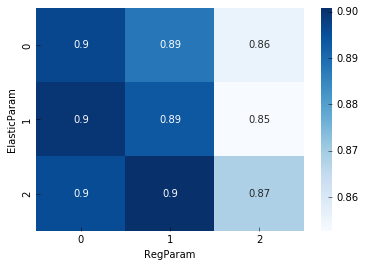

In [50]:
import seaborn as sns
sns.heatmap(grid_reshape, cmap='Blues', annot=True)
plt.xlabel('RegParam')
plt.ylabel('ElasticParam')

In [34]:
# evaluate the optimal model quantitatively.

evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderPR")
print ("Area under precision-recall curve - training:",evaluator.evaluate(train_predictions))
print ("Area under precision-recall curve - testing:",evaluator.evaluate(test_predictions))

Area under precision-recall curve - training: 0.908030706798117
Area under precision-recall curve - testing: 0.8957374196681749


In [35]:
print ("Test set accuracy:",test_predictions.filter((test_predictions['prediction'] == test_predictions['label'])).count() / test_predictions.select("label").count())

Test set accuracy: 0.7254445737078278


# Running Experiments for Other Feature types
Below sections fit pipelines and generate grid search results for other feature types: Ngram, Hashing Vector, Word2Vec

In [36]:
# packages
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## For Hashing Vectors

In [52]:
def get_hashvector_pipeline(hv_param=500,ml_param=0):
    #Constructing a pipeline for hash vetctors

    # String to index transformer e.g. Score is a string of 1-5, but need it as an index which can be one-hot encoded
    scoreIndexer = StringIndexer(inputCol = "Score", outputCol = "indexedScore")

    # One-hot encoder on the indexed feature(s)
    scoreEncoder = OneHotEncoder(inputCol = "indexedScore", outputCol = "scoreVec")

    #We split each sentence into words using Tokenizer. 
    #Tokenizer only splits by white spaces
    tokenizer = Tokenizer().setInputCol("reviewTextNoPunc").setOutputCol("words")

    #Remove stopwords
    remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

    #For each sentence (bag of words),use HashingTF to hash the sentence into a feature vector. 
    hashingTF = HashingTF().setNumFeatures(hv_param).setInputCol("filtered").setOutputCol("rawFeatures")

    #We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
    idf = IDF().setInputCol("rawFeatures").setOutputCol("idfFeature").setMinDocFreq(0)

    # Assemble the vector of features
    assembler = VectorAssembler(inputCols = ["scoreVec", "idfFeature", "reviewCount"], outputCol = "features")

    #Our feature vectors could then be passed to a learning algorithm.
    # Create a Logistic regression model
    lr = LogisticRegression(elasticNetParam=ml_param, labelCol = "label")
    
    #Then basically we connect all the steps above to create one pipeline
    pipeline=Pipeline(stages=[scoreIndexer, scoreEncoder, tokenizer, remover, hashingTF, idf, assembler, lr])
    return pipeline

def get_hashvector_paramgrid(value_list):
    hashingTF = HashingTF().setNumFeatures(500).setInputCol("filtered").setOutputCol("rawFeatures")
    lr = LogisticRegression(labelCol = "label")
    #and associated params
    paramGrid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures,value_list)\
        .addGrid(lr.elasticNetParam, [0]) \
        .build() \
        #.addGrid(lr.setRegParam, lr_values)\
    return paramGrid

## For nGrams

In [53]:
def get_ngram_pipeline(ng_param=2,ml_param=0):
    #Constructing a pipeline for hash vetctors

    # String to index transformer e.g. Score is a string of 1-5, but need it as an index which can be one-hot encoded
    scoreIndexer = StringIndexer(inputCol = "Score", outputCol = "indexedScore")

    # One-hot encoder on the indexed feature(s)
    scoreEncoder = OneHotEncoder(inputCol = "indexedScore", outputCol = "scoreVec")

    #We split each sentence into words using Tokenizer. 
    #Tokenizer only splits by white spaces
    tokenizer = Tokenizer().setInputCol("reviewTextNoPunc").setOutputCol("words")

    #Remove stopwords
    #remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

    #For each sentence (bag of words), generate n-grams
    nGram = NGram(n=ng_param, inputCol="words", outputCol="rawFeatures") 
    vectorizer = CountVectorizer(inputCol="rawFeatures", outputCol="rawFeaturesvec")

    #We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
    idf = IDF().setInputCol("rawFeaturesvec").setOutputCol("idfFeature").setMinDocFreq(0)

    # Assemble the vector of features
    assembler = VectorAssembler(inputCols = ["scoreVec", "idfFeature", "reviewCount"], outputCol = "features")

    #Our feature vectors could then be passed to a learning algorithm.
    # Create a Logistic regression model
    lr = LogisticRegression(elasticNetParam=ml_param, labelCol = "label")

    #Then basically we connect all the steps above to create one pipeline
    pipeline=Pipeline(stages=[scoreIndexer, scoreEncoder, tokenizer, nGram, vectorizer, idf,assembler, lr])
    return pipeline

def get_ngram_paramgrid(value_list):
    nGram = NGram(n=2, inputCol="filtered", outputCol="rawFeatures") 
    lr = LogisticRegression(labelCol = "label")
    #and associated params
    paramGrid = ParamGridBuilder()\
        .addGrid(nGram.n,value_list)\
        .addGrid(lr.elasticNetParam, [0]) \
        .build() \
        #.addGrid(lr.setRegParam, lr_values)\
    return paramGrid

## For Word2Vec

In [54]:
def get_w2v_pipeline(w2_param=3,ml_param=0):
    #Constructing a pipeline for Word2Vector

    # String to index transformer e.g. Score is a string of 1-5, but need it as an index which can be one-hot encoded
    scoreIndexer = StringIndexer(inputCol = "Score", outputCol = "indexedScore")

    # One-hot encoder on the indexed feature(s)
    scoreEncoder = OneHotEncoder(inputCol = "indexedScore", outputCol = "scoreVec")

    #We split each sentence into words using Tokenizer. 
    #Tokenizer only splits by white spaces
    tokenizer = Tokenizer().setInputCol("reviewTextNoPunc").setOutputCol("words")

    #Remove stopwords
    #remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

    #For each sentence (bag of words), generate word2vec representation
    w2v = Word2Vec(vectorSize=w2_param, minCount=0, inputCol="words", outputCol="rawfeatures")

    #We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
    idf = IDF().setInputCol("rawfeatures").setOutputCol("idfFeature").setMinDocFreq(0)

    # Assemble the vector of features
    assembler = VectorAssembler(inputCols = ["scoreVec", "idfFeature", "reviewCount"], outputCol = "features")

    #Our feature vectors could then be passed to a learning algorithm.
    # Create a Logistic regression model
    lr = LogisticRegression(elasticNetParam=ml_param, labelCol = "label")

    #Then basically we connect all the steps above to create one pipeline
    pipeline=Pipeline(stages=[scoreIndexer, scoreEncoder, tokenizer, w2v, idf, assembler, lr])
    return pipeline


def get_w2v_paramgrid(value_list):
    w2v = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="features")
    lr = LogisticRegression(labelCol = "label")
    #and associated params
    paramGrid = ParamGridBuilder()\
        .addGrid(w2v.vectorSize, value_list)\
        .addGrid(lr.elasticNetParam, [0]) \
        .build()
        #.addGrid(lr.setRegParam, lr_values)\
    return paramGrid

## Now actually run grid search over different feature types
Print results to dataframe csv to allow graphics generation in a different notebook: goal is to be able to generate various graphics from grid search results without having to recalculate the whole thing

Note: code  changed to run over dimensions of the grid search sequentially rather than in parallel: this was done because the whole grid search kept crashing out partway due to VPN connection issues and competition for server memory with other users: safer to print it on each loop!

### First define some functions 
For interpreting parameter grids and recording CPU time usage etc

In [55]:
import sys
from io import TextIOWrapper, BytesIO

def get_all_times(command, args):
    # setup the environment
    old_stdout = sys.stdout
    sys.stdout = TextIOWrapper(BytesIO(), sys.stdout.encoding)

    %time model=command(*args)
    sys.stdout.seek(0)
    out = sys.stdout.read()

    sys.stdout.close()
    sys.stdout = old_stdout

    times = out
    
    try:
        model=command(*args)
        return (model,times)
    except Exception as ex:
        print(ex)
        return (None,times)
    
    

In [56]:
def get_param_df(paramGrid, metrics=[]):
    params_df = pd.DataFrame(index=[])

    for i, param in enumerate(paramGrid):
        col_names=[]
        param_values=[]
        for param_name in param.keys():
            col_name = param_name.parent.split('_')[0] + '_' + param_name.name 
            col_names.append(col_name)
            param_value = param[param_name]
            param_values.append(param_value)
            
        this_result=pd.DataFrame([param_values], columns=col_names)
        if metrics != []:
            this_result['metric'] = metrics[i]
        params_df = pd.concat([params_df,this_result],axis=0)
    return params_df    

### Finally, run the full grid search over training set sizes, param type, param features

Note: This gridsearch outputs to a results csv which is designed to be read by the Graphics notebook, not read here!!!

The reason for this is to be able to pivot the results in a more agile way without rerunning any grid searches

In [ ]:
#set config here: currently set to very small grid search dimensions for testing purposes

feat_types = ['word2vec','hashing_vector','ngram']
pipeline_dict = {'hashing_vector':get_hashvector_pipeline, 'ngram' : get_ngram_pipeline, 'word2vec' : get_w2v_pipeline }
param_dict = {'hashing_vector':get_hashvector_paramgrid, 'ngram' : get_ngram_paramgrid, 'word2vec' : get_w2v_paramgrid }
values_dict = {'hashing_vector':[[10],[100],[1000],[10000]], 'word2vec':[[10], [100],[1000]], 'ngram':[[2]]}

el_param=0

#train_size = [0.10, .20, .30, .40, .50, .60, .70, .80, .90, 0.99]
train_sizes = [0.01]
#train_sizes = [0.5,0.99]

models=[]
times_list=[]
results_df=pd.DataFrame(index=[])

for train_size in train_sizes:
    print('Running training set size: {}'.format(train_size))
    train_set_sampled = train_set.sample(False, train_size, seed=123)
    train_set_sampled.persist(StorageLevel.MEMORY_AND_DISK)
    for feat in feat_types:
        print('Processing feature type {}'.format(feat))
        
        for paramgrid_values in values_dict[feat]:
            pipeline = pipeline_dict[feat](paramgrid_values[0], el_param)
            print('Pipeline: {}'.format(pipeline))
            #paramgrid_values = values_dict[feat]
            print('Paramgrid values: {}'.format(paramgrid_values))
            paramGrid = param_dict[feat](paramgrid_values)
            print('Paramgrid: {}'.format(paramGrid))

            tvs = TrainValidationSplit(estimator=pipeline,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=BinaryClassificationEvaluator().setMetricName("areaUnderPR"),
                                   # 80% of the data will be used for training, 20% for validation.
                                   trainRatio=0.8)

            tuned_model,time = get_all_times(tvs.fit,(train_set_sampled,)) 
            models.append(tuned_model)
            times_list.append(time)
            print('AUC returned: {}'.format(tuned_model.validationMetrics))
            this_result_df = get_param_df(paramGrid,tuned_model.validationMetrics)
            this_result_df['calc_time'] = time
            this_result_df['feature_type'] = feat
            this_result_df['train_set_size'] = train_size
            results_df = pd.concat([results_df,this_result_df],axis=0)
            results_df.to_csv('gridsearch_results.csv',sep='#')

            #tuned_model,times = tvs2.fit(train_set)
            print('Feature type {} got tuned model: {} and time results: {}'.format(feat, tuned_model, time))

print(results_df)

Running training set size: 0.01
Processing feature type word2vec
Pipeline: Pipeline_4d1f914eacf2dcf3d672
Paramgrid values: [10]
Paramgrid: [{Param(parent='Word2Vec_470fbc2c943d243e62b4', name='vectorSize', doc='the dimension of codes after transforming from words'): 10, Param(parent='LogisticRegression_48ad9c9fc73a1e2168d3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0}]
